# Experiments on Scenario A with FastAI

This series of experiments was performed on a rebalanced subset of the Data from Scenario A where the new dataset is created by reducing a random sample of Non-Tor data to the equivalent size of the Tor data. The new dataset is comprised of exactly 50% Tor connection data and 50% Non-Tor connection data

In [1]:
import os, sys, glob, pprint
from fastai.tabular import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import pandas as pd
import numpy as np

# set up pretty printer for easier data evaluation
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print('libraries loaded')

libraries loaded


##  Prepare the data

The balanced datasets have already been balanced and cleaned for use, but we will do some re-cleaning to make sure the experiments without throwing an error. The files and their path are listed here

NOTE: We manually went into the csv files after converting them from arff to remove Infinity cells, NaN cells, and to fill the empty initial column cell with the title Index. The reason we filled the initial column cell is because the fastAI library was throwing errors due to the empty cell title

In [2]:
dataPath: str = './balancedSetA'
data: list = [
    'downsampled_merged_5s.csv',
    'downsampled_SelectedFeatures-10s-TOR-NonTor.csv',
    'downsampled_SelectedFeatures-15s-TOR-NonTor.csv',
    'downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv',
    'downsampled_TimeBasedFeatures-15s-TOR-NonTOR-15.csv',
    'downsampled_TimeBasedFeatures-15s-TOR-NonTOR-85.csv',
    'downsampled_TimeBasedFeatures-30s-TORNonTor.csv',
    'downsampled_TimeBasedFeatures-30s-TORNonTOR-15.csv',
    'downsampled_TimeBasedFeatures-30s-TORNonTOR-85.csv',
    'downsampled_TimeBasedFeatures-60s-TOR-NonTor.csv',
    'downsampled_TimeBasedFeatures-60s-TOR-NonTOR-15.csv',
    'downsampled_TimeBasedFeatures-60s-TOR-NonTOR-85.csv',
    'downsampled_TimeBasedFeatures-120s-TOR-NonTor.csv',
    'downsampled_TimeBasedFeatures-120s-TOR-NonTOR-15.csv',
    'downsampled_TimeBasedFeatures-120s-TOR-NonTOR-85.csv'
]


def get_file_path(file):
    return os.path.join(dataPath, file)

csvFiles: list = list(map(get_file_path, data))

print(f'We will be running: {len(csvFiles)} experiments\n')
pretty(csvFiles)

We will be running: 15 experiments

[   './balancedSetA/downsampled_merged_5s.csv',
    './balancedSetA/downsampled_SelectedFeatures-10s-TOR-NonTor.csv',
    './balancedSetA/downsampled_SelectedFeatures-15s-TOR-NonTor.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR-15.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR-85.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-30s-TORNonTor.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-30s-TORNonTOR-15.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-30s-TORNonTOR-85.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-60s-TOR-NonTor.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-60s-TOR-NonTOR-15.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-60s-TOR-NonTOR-85.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-120s-TOR-NonTor.csv',
    './balancedSetA/downsampled_TimeBasedFeatures-

Here we create a series of helper functions to load, re-clean, and cache the data

In [3]:
def clean(df):
    # let's strip the whitspaces from column names
    df = df.rename(str.strip, axis='columns')

    # drop missing values/NaN etc.
    df.dropna(inplace=True)

    # drop Infinity rows and NaN string from each column
    for col in df.columns:
        
        indexNames = df[df[col]=='Infinity'].index
        if not indexNames.empty:
            print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
            df.drop(indexNames, inplace=True)

        indexNames = df[df[col]=='inf'].index
        if not indexNames.empty:
            print('deleting {} rows with inf in column {}'.format(len(indexNames), col))
            df.drop(indexNames, inplace=True)

        indexNames = df[df[col]=='NaN'].index
        if not indexNames.empty:
            print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
            df.drop(indexNames, inplace=True)

        indexNames = df[df[col]=='nan'].index
        if not indexNames.empty:
            print('deleting {} rows with nan in column {}'.format(len(indexNames), col))
            df.drop(indexNames, inplace=True)

    # drop  Source IP and Destination IP columns if they are present        
    if 'Source IP' in df.columns:
        df.drop(columns=['Source IP'], inplace=True)

    if 'Destination IP' in df.columns:
        df.drop(columns=['Destination IP'], inplace=True)
            
    # convert  Flow Bytes/s object & Flow Packets/s object into float type if they are present
    if 'Flow Bytes/s' in df.columns:
        df['Flow Bytes/s'] = df['Flow Bytes/s'].astype('float64')

    if 'Flow Packets/s' in df.columns:
        df['Flow Packets/s'] = df['Flow Packets/s'].astype('float64')

    return df
    

def load_data(filePath):
    
    # slice off the ./ from the filePath
    if filePath[0] == '.' and filePath[1] == '/':
        filePathClean: str = filePath[2::]
        pickleDump: str = f'./processed/{filePathClean}.pickle'
    else:
        pickleDump: str = f'./processed/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and clean it before caching it
    else:
        df = pd.read_csv(filePath, low_memory=False)
        df = clean(df)
        
        df.to_pickle(pickleDump)
    
    return df

Here we use the helper functions to map over the experiment files and load the csv files into memory

In [4]:
dataframes: list = list(map(load_data, csvFiles))

Loading Dataset: ./balancedSetA/downsampled_merged_5s.csv
	To Dataset Cache: ./processed/balancedSetA/downsampled_merged_5s.csv.pickle

Loading Dataset: ./balancedSetA/downsampled_SelectedFeatures-10s-TOR-NonTor.csv
	To Dataset Cache: ./processed/balancedSetA/downsampled_SelectedFeatures-10s-TOR-NonTor.csv.pickle

Loading Dataset: ./balancedSetA/downsampled_SelectedFeatures-15s-TOR-NonTor.csv
	To Dataset Cache: ./processed/balancedSetA/downsampled_SelectedFeatures-15s-TOR-NonTor.csv.pickle

Loading Dataset: ./balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv
	To Dataset Cache: ./processed/balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv.pickle

Loading Dataset: ./balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR-15.csv
	To Dataset Cache: ./processed/balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR-15.csv.pickle

Loading Dataset: ./balancedSetA/downsampled_TimeBasedFeatures-15s-TOR-NonTOR-85.csv
	To Dataset Cache: ./processed/balancedSetA/downsa

With the data cleaned, packaged, and loaded into memory, we now can create the functions to run the experiments

In [5]:
def run_experiment(experiment_number, df):
    try:
        dep_var = 'label'
        x = df[df[dep_var]=='TOR']
    except:
        dep_var = 'class1'
        x = df[df[dep_var]=='TOR']

    unused_categories: list = []
        
    if 'Source Port' in df.columns:
        unused_categories.append('Source Port')
    if 'Destination Port' in df.columns:
        unused_categories.append('Destination Port')
    if 'Protocol' in df.columns:
        unused_categories.append('Protocol')
    if 'Index' in df.columns:
        unused_categories.append('Index')
    if 'Unnamed: 0' in df.columns:
        unused_categories.append('Unnamed: 0')
    
    selected_features = list(set(df) - set(unused_categories) - set([dep_var]))
    print('Selected Features:')
    pretty(selected_features)
    print('\nDependent Variable:', dep_var)
    
    procs = [FillMissing, Categorify, Normalize]
    sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
    
    for train_idx, test_idx in sss.split(df.index, df[dep_var]):
        data_fold = (TabularList.from_df(df, path=dataPath, cat_names=unused_categories, cont_names=selected_features, procs=procs)
            .split_by_idxs(train_idx, test_idx)
            .label_from_df(cols=dep_var)
            .databunch())
        
        
        # create model and learn
        model = tabular_learner(data_fold, layers=[50, 28], metrics=accuracy, callback_fns=ShowGraph)
        model.fit_one_cycle(cyc_len=10) #
        model.save('{}.model'.format(os.path.basename(csvFiles[experiment_number])))
    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))
    
    preds, y, losses = model.get_preds(with_loss=True)
    interp = ClassificationInterpretation(model, preds, y, losses)
    interp.plot_confusion_matrix()


def experiment_metadata(experiment_number, df):
    print(f'Experiment #{experiment_number + 1}\n\ndataset:\t\t{data[experiment_number]}\nshape:\t\t\t{df.shape}')
    try:
        id_column = 'label'
        tor_data = df[df[id_column]=='TOR']
        non_tor_data = df[df[id_column]=='nonTOR']
        if len(non_tor_data.index) == 0:
            non_tor_data = df[df[id_column] == 'NONTOR']
    except:
        id_column = 'class1'
        tor_data = df[df[id_column]=='TOR']
        non_tor_data = df[df[id_column]=='nonTOR']
        if len(non_tor_data.index) == 0:
            non_tor_data = df[df[id_column] == 'NONTOR']
    print(f'total TOR data:\t\t{len(tor_data.index)}\ntotal Non-TOR data:\t{len(non_tor_data.index)}\n\n')


Lets test that the experiments run when given an arbitrary set of data

In [6]:
experiment_metadata(12, dataframes[12])

Experiment #13

dataset:		downsampled_TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(940, 25)
total TOR data:		470
total Non-TOR data:	470




Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.728242,0.660908,0.579787,00:01
1,0.539187,0.453264,0.952128,00:01
2,0.383838,0.173263,0.978723,00:01
3,0.275199,0.074304,0.989362,00:01
4,0.204417,0.055858,0.989362,00:01
5,0.153729,0.051914,0.989362,00:01
6,0.117871,0.050208,0.989362,00:01
7,0.093299,0.045668,0.989362,00:01
8,0.074227,0.045944,0.989362,00:01
9,0.059562,0.046128,0.989362,00:01


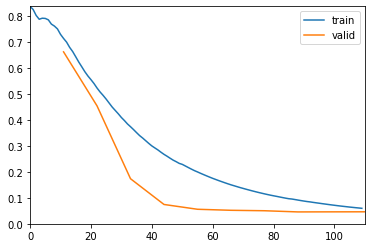

loss 0.04612834379076958: accuracy: 98.94%


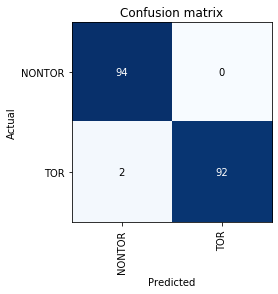

In [7]:
run_experiment(12, dataframes[12])

Since our experiments are all neatly packaged in lists, we have created a simple generator to run each experiment

In [8]:
def run_experiments(dataframes):
    for experiment_number, df in enumerate(dataframes):
        experiment_metadata(experiment_number, df)
        yield run_experiment(experiment_number, df)

In [9]:
experiment = run_experiments(dataframes)

Here we run all of the experiments now that they have been set up

Experiment #1

dataset:		downsampled_merged_5s.csv
shape:			(29014, 28)
total TOR data:		14507
total Non-TOR data:	14507


Selected Features:
[   'Bwd IAT Max',
    'Idle Max',
    'Active Std',
    'Fwd IAT Mean',
    'Fwd IAT Max',
    'Active Mean',
    'Idle Min',
    'Active Max',
    'Fwd IAT Min',
    'Idle Mean',
    'Bwd IAT Mean',
    'Flow IAT Mean',
    'Flow Bytes/s',
    'Active Min',
    'Flow IAT Max',
    'Flow Duration',
    'Flow Packets/s',
    'Flow IAT Std',
    'Flow IAT Min',
    'Fwd IAT Std',
    'Bwd IAT Std',
    'Idle Std',
    'Bwd IAT Min']

Dependent Variable: label


epoch,train_loss,valid_loss,accuracy,time
0,0.032496,0.011521,0.998104,01:27
1,0.006879,0.008393,0.997415,01:18
2,0.007407,0.004216,0.998449,01:16
3,0.005266,0.002656,0.998966,01:19
4,0.001400,0.003617,0.999483,01:18
5,0.000999,0.002158,0.999483,01:18
6,0.000036,0.004037,0.998966,01:21
7,0.000042,0.001798,0.999828,01:18
8,0.000005,0.002805,0.999311,01:23
9,0.000004,0.002590,0.999311,01:17


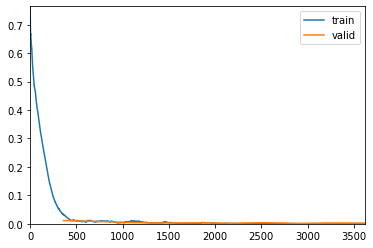

loss 0.0025904832873493433: accuracy: 99.93%


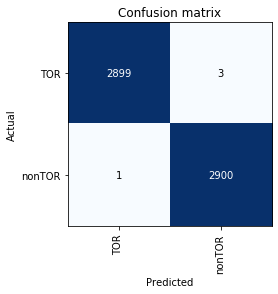

In [10]:
next(experiment)

Experiment #2

dataset:		downsampled_SelectedFeatures-10s-TOR-NonTor.csv
shape:			(16088, 28)
total TOR data:		8044
total Non-TOR data:	8044


Selected Features:
[   'Bwd IAT Max',
    'Idle Max',
    'Active Std',
    'Fwd IAT Mean',
    'Fwd IAT Max',
    'Active Mean',
    'Idle Min',
    'Active Max',
    'Fwd IAT Min',
    'Idle Mean',
    'Bwd IAT Mean',
    'Flow IAT Mean',
    'Flow Bytes/s',
    'Active Min',
    'Flow IAT Max',
    'Flow Duration',
    'Flow Packets/s',
    'Flow IAT Std',
    'Flow IAT Min',
    'Fwd IAT Std',
    'Bwd IAT Std',
    'Idle Std',
    'Bwd IAT Min']

Dependent Variable: label


epoch,train_loss,valid_loss,accuracy,time
0,0.140608,0.041515,0.992853,00:13
1,0.020384,0.018127,0.995028,00:07
2,0.008715,0.013285,0.995028,00:07
3,0.003541,0.009457,0.997514,00:08
4,0.004937,0.003556,0.998446,00:08
5,0.001384,0.000796,0.999689,00:08
6,0.001046,0.000332,1.000000,00:08
7,0.000372,0.000088,1.000000,00:08
8,0.000051,0.000037,1.000000,00:08
9,0.000055,0.000040,1.000000,00:08


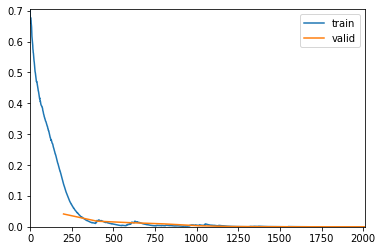

loss 4.0467763028573245e-05: accuracy: 100.00%


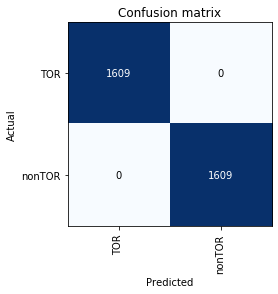

In [11]:
next(experiment)

Experiment #3

dataset:		downsampled_SelectedFeatures-15s-TOR-NonTor.csv
shape:			(6628, 6)
total TOR data:		3314
total Non-TOR data:	3314


Selected Features:
[   'min_biat',
    'max_biat',
    'max_fiat',
    'min_fiat']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.526337,0.479529,0.722474,00:03
1,0.199893,0.826313,0.680241,00:02
2,0.120014,0.405561,0.745852,00:03
3,0.084785,1.143999,0.610860,00:03
4,0.042827,1.374037,0.660634,00:02
5,0.016583,1.035027,0.674962,00:03
6,0.007084,1.677246,0.649321,00:02
7,0.002911,1.344615,0.673454,00:03
8,0.001356,1.322251,0.675716,00:02
9,0.001064,1.961555,0.625943,00:03


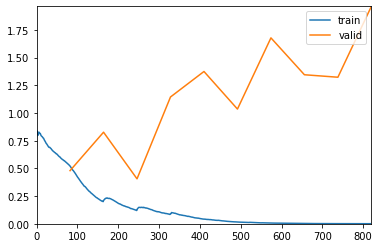

loss 1.9615546464920044: accuracy: 62.59%


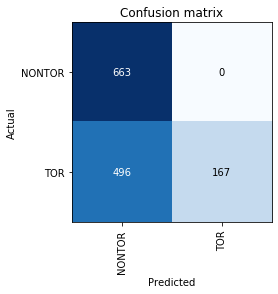

In [12]:
next(experiment)

Experiment #4

dataset:		downsampled_TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(6628, 25)
total TOR data:		3314
total Non-TOR data:	3314


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.304425,0.124697,0.980392,00:03
1,0.102637,0.050073,0.987934,00:03
2,0.043043,0.064024,0.983409,00:02
3,0.018382,0.079988,0.983409,00:03
4,0.009104,0.089152,0.981900,00:02
5,0.003606,0.103171,0.978884,00:05
6,0.003055,0.091209,0.981146,00:02
7,0.001179,0.122729,0.980392,00:03
8,0.001001,0.112951,0.981146,00:02
9,0.001452,0.114377,0.981146,00:02


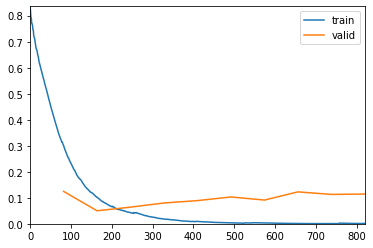

loss 0.11437719315290451: accuracy: 98.11%


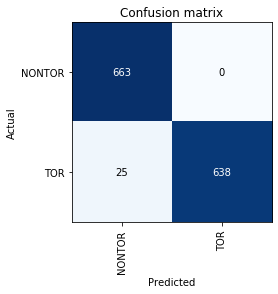

In [13]:
next(experiment)

Experiment #5

dataset:		downsampled_TimeBasedFeatures-15s-TOR-NonTOR-15.csv
shape:			(1030, 25)
total TOR data:		515
total Non-TOR data:	515


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.841403,0.687610,0.543689,00:01
1,0.563939,0.477311,0.936893,00:01
2,0.405914,0.217053,0.975728,00:01
3,0.292748,0.106341,0.980583,00:01
4,0.213894,0.083017,0.980583,00:01
5,0.159167,0.075670,0.980583,00:01
6,0.120891,0.077905,0.980583,00:01
7,0.093283,0.072474,0.980583,00:01
8,0.073262,0.073646,0.980583,00:01
9,0.058280,0.073446,0.980583,00:01


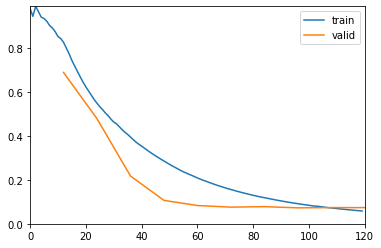

loss 0.07344569265842438: accuracy: 98.06%


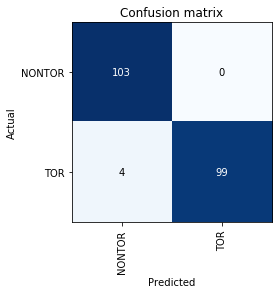

In [14]:
next(experiment)

Experiment #6

dataset:		downsampled_TimeBasedFeatures-15s-TOR-NonTOR-85.csv
shape:			(5598, 25)
total TOR data:		2799
total Non-TOR data:	2799


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.511786,0.250977,0.955357,00:02
1,0.182925,0.066124,0.981250,00:02
2,0.060731,0.107192,0.975000,00:02
3,0.023786,0.194277,0.967857,00:02
4,0.014174,0.135403,0.970536,00:02
5,0.005151,0.152033,0.970536,00:02
6,0.004052,0.113844,0.979464,00:02
7,0.001858,0.128551,0.979464,00:02
8,0.001117,0.146309,0.975000,00:02
9,0.000630,0.143814,0.976786,00:02


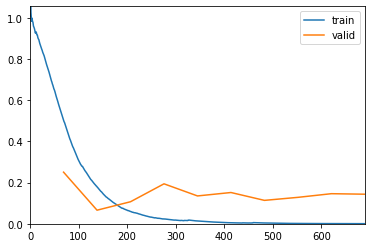

loss 0.14381401240825653: accuracy: 97.68%


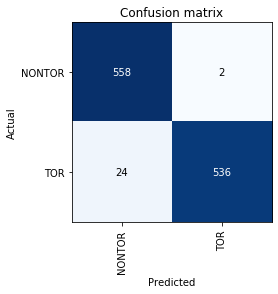

In [15]:
next(experiment)

Experiment #7

dataset:		downsampled_TimeBasedFeatures-30s-TORNonTor.csv
shape:			(3542, 25)
total TOR data:		1771
total Non-TOR data:	1771


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.411098,0.252793,0.973202,00:02
1,0.182936,0.064210,0.985896,00:02
2,0.081124,0.059322,0.985896,00:02
3,0.038265,0.061622,0.983075,00:02
4,0.020525,0.083575,0.980254,00:02
5,0.011296,0.082004,0.980254,00:02
6,0.005740,0.105850,0.980254,00:02
7,0.003333,0.091386,0.980254,00:02
8,0.002111,0.096212,0.980254,00:02
9,0.001270,0.092583,0.980254,00:02


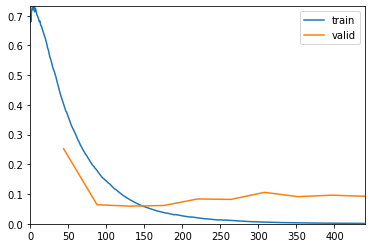

loss 0.09258253872394562: accuracy: 98.03%


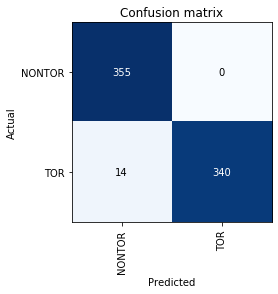

In [16]:
next(experiment)

Experiment #8

dataset:		downsampled_TimeBasedFeatures-30s-TORNonTOR-15.csv
shape:			(530, 25)
total TOR data:		265
total Non-TOR data:	265


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.845789,0.698541,0.500000,00:01
1,0.714075,0.635016,0.518868,00:01
2,0.548032,0.463749,0.962264,00:01
3,0.429368,0.276725,0.990566,00:01
4,0.344037,0.157898,0.990566,00:01
5,0.285706,0.099888,0.990566,00:01
6,0.239106,0.074820,0.990566,00:01
7,0.206539,0.062263,0.990566,00:01
8,0.181549,0.057917,0.990566,00:01
9,0.159575,0.055809,0.990566,00:01


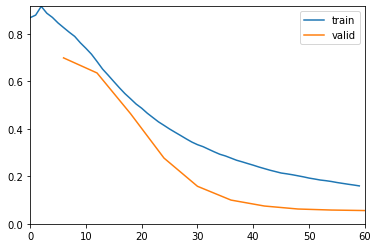

loss 0.05580882355570793: accuracy: 99.06%


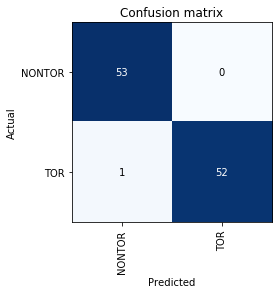

In [17]:
next(experiment)

Experiment #9

dataset:		downsampled_TimeBasedFeatures-30s-TORNonTOR-85.csv
shape:			(3012, 25)
total TOR data:		1506
total Non-TOR data:	1506


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.433215,0.321982,0.968491,00:02
1,0.219854,0.087219,0.978441,00:02
2,0.110296,0.060406,0.981758,00:02
3,0.060618,0.103202,0.975124,00:02
4,0.031262,0.109426,0.976783,00:02
5,0.016033,0.104032,0.976783,00:02
6,0.008394,0.108581,0.975124,00:02
7,0.004912,0.114238,0.976783,00:02
8,0.002932,0.104885,0.978441,00:02
9,0.003014,0.108607,0.976783,00:03


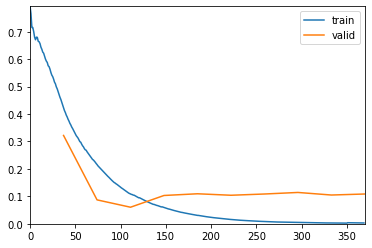

loss 0.10860677063465118: accuracy: 97.68%


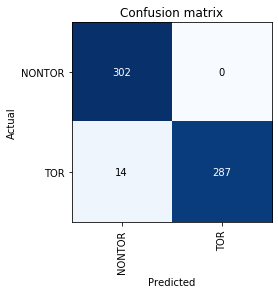

In [18]:
next(experiment)

Experiment #10

dataset:		downsampled_TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(1828, 25)
total TOR data:		914
total Non-TOR data:	914


Selected Features:
[   'max_biat',
    'max_idle',
    'mean_fiat',
    'min_idle',
    'std_biat',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_fiat',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.562101,0.597694,0.909836,00:01
1,0.330911,0.123979,0.983607,00:02
2,0.196884,0.046307,0.994536,00:02
3,0.120348,0.038868,0.994536,00:01
4,0.076093,0.039532,0.991803,00:01
5,0.050166,0.045179,0.986339,00:02
6,0.033195,0.036977,0.991803,00:01
7,0.022530,0.039821,0.991803,00:01
8,0.016403,0.035644,0.991803,00:01
9,0.011543,0.036780,0.991803,00:01


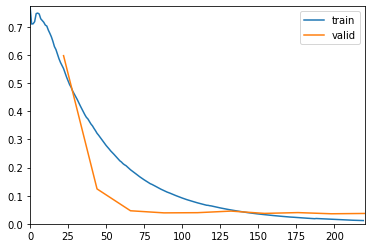

loss 0.0367802269756794: accuracy: 99.18%


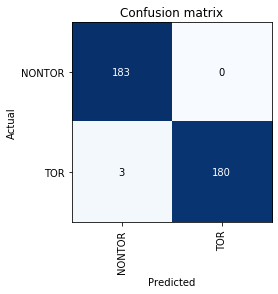

In [19]:
next(experiment)

Experiment #11

dataset:		downsampled_TimeBasedFeatures-60s-TOR-NonTOR-15.csv
shape:			(272, 25)
total TOR data:		136
total Non-TOR data:	136


Selected Features:
[   'max_biat',
    'max_idle',
    'mean_fiat',
    'min_idle',
    'std_biat',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_fiat',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.885143,0.698198,0.490909,00:01
1,0.812479,0.680375,0.618182,00:01
2,0.698489,0.632610,0.927273,00:01
3,0.595806,0.562759,0.963636,00:01
4,0.511773,0.481136,0.963636,00:01
5,0.451088,0.400948,0.963636,00:01
6,0.402580,0.331404,0.963636,00:01
7,0.359049,0.280200,0.963636,00:01
8,0.325809,0.243498,0.963636,00:01
9,0.300593,0.218560,0.963636,00:01


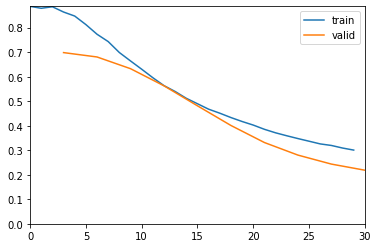

loss 0.21856002509593964: accuracy: 96.36%


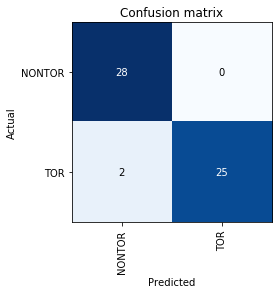

In [20]:
next(experiment)

Experiment #12

dataset:		downsampled_TimeBasedFeatures-60s-TOR-NonTOR-85.csv
shape:			(1556, 25)
total TOR data:		778
total Non-TOR data:	778


Selected Features:
[   'max_biat',
    'max_idle',
    'mean_fiat',
    'min_idle',
    'std_biat',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_fiat',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.562423,0.593651,0.868590,00:02
1,0.346408,0.177072,0.993590,00:01
2,0.217117,0.040442,0.996795,00:01
3,0.139781,0.025246,0.996795,00:01
4,0.093812,0.020449,0.996795,00:01
5,0.063074,0.021153,0.993590,00:01
6,0.043433,0.016834,0.996795,00:02
7,0.030847,0.015334,0.996795,00:01
8,0.022108,0.018305,0.993590,00:01
9,0.016311,0.019093,0.993590,00:03


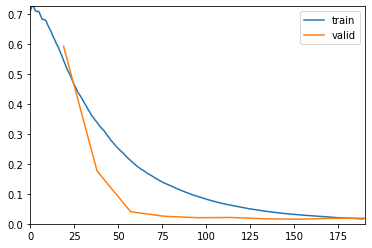

loss 0.019093332812190056: accuracy: 99.36%


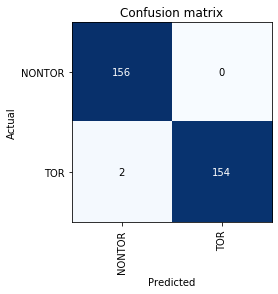

In [21]:
next(experiment)

Experiment #13

dataset:		downsampled_TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(940, 25)
total TOR data:		470
total Non-TOR data:	470


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.899390,0.702289,0.537234,00:01
1,0.636106,0.503327,0.968085,00:01
2,0.438700,0.191909,0.973404,00:01
3,0.315759,0.101018,0.973404,00:01
4,0.232220,0.076668,0.973404,00:01
5,0.175387,0.067104,0.973404,00:01
6,0.134750,0.063765,0.978723,00:01
7,0.104795,0.062130,0.978723,00:01
8,0.083520,0.060359,0.978723,00:01
9,0.067441,0.060981,0.978723,00:01


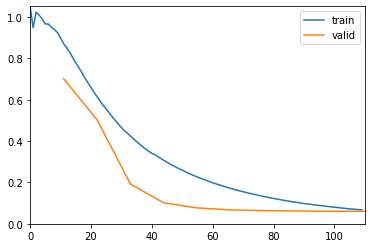

loss 0.06098119914531708: accuracy: 97.87%


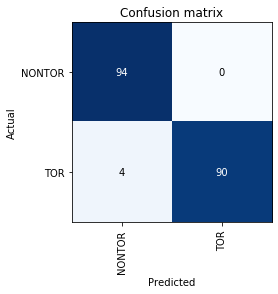

In [22]:
next(experiment)

Experiment #14

dataset:		downsampled_TimeBasedFeatures-120s-TOR-NonTOR-15.csv
shape:			(132, 25)
total TOR data:		66
total Non-TOR data:	66


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.858914,0.701371,0.444444,00:01
1,0.845865,0.696500,0.444444,00:01
2,0.819766,0.682722,0.444444,00:01
3,0.779890,0.663632,0.518519,00:01
4,0.731947,0.640263,0.518519,00:01
5,0.675475,0.615603,0.814815,00:01
6,0.625724,0.592100,0.888889,00:01
7,0.584936,0.571978,1.000000,00:01
8,0.551189,0.557690,1.000000,00:01
9,0.523367,0.547817,1.000000,00:01


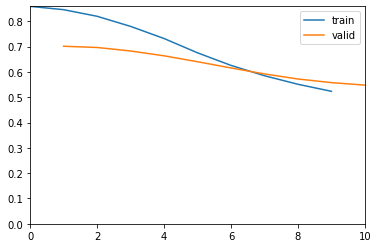

loss 0.5478166341781616: accuracy: 100.00%


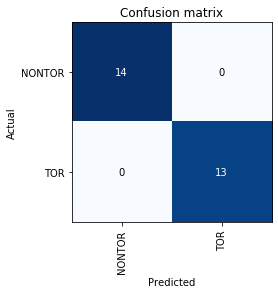

In [23]:
next(experiment)

Experiment #15

dataset:		downsampled_TimeBasedFeatures-120s-TOR-NonTOR-85.csv
shape:			(808, 25)
total TOR data:		404
total Non-TOR data:	404


Selected Features:
[   'max_biat',
    'total_biat',
    'mean_fiat',
    'max_idle',
    'total_fiat',
    'min_idle',
    'std_flowiat',
    'flowPktsPerSecond',
    'min_biat',
    'mean_biat',
    'mean_idle',
    'flowBytesPerSecond',
    'min_flowiat',
    'duration',
    'std_active',
    'max_fiat',
    'max_active',
    'min_fiat',
    'std_idle',
    'mean_flowiat',
    'max_flowiat',
    'mean_active',
    'min_active']

Dependent Variable: class1


epoch,train_loss,valid_loss,accuracy,time
0,0.793047,0.684858,0.691358,00:01
1,0.555452,0.472441,1.000000,00:01
2,0.396418,0.194416,1.000000,00:01
3,0.294774,0.074599,1.000000,00:01
4,0.224214,0.043402,1.000000,00:01
5,0.173477,0.034062,1.000000,00:01
6,0.135461,0.032245,1.000000,00:01
7,0.107174,0.031865,1.000000,00:01
8,0.086470,0.031545,1.000000,00:01
9,0.070444,0.031223,1.000000,00:01


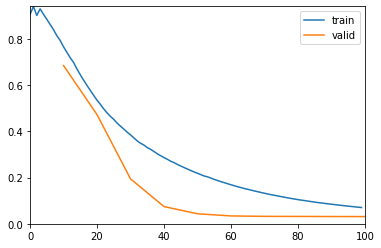

loss 0.031223075464367867: accuracy: 100.00%


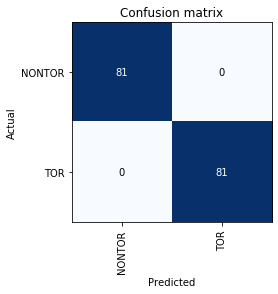

In [24]:
next(experiment)